In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().home()/"code"/"XAI"/"models"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"relavance"))
sys.path.append(str(Path().home()/"code"/"XAI"/"models"/"mnist"))

import torch
import torch.nn as nn
import numpy as np

from models.saliency.saliency import VanillaGrad, GradInput
from models.deconv.deconvnet import DeconvNet
from models.relavance.lrp import LRP
from models.reshape import Reshape
from models.mnist.mnistModels import MNISTmodel
from models.mnist.mnistTrain import build_dataset
from models.utils import *

In [2]:
activation_types = ["relu", "tanh", "sigmoid", "softplus"]
model_types = ["dnn", "cnn"]
args = dict(
    root = str(Path().home()/"code"/"data"),
    project_path = Path().home()/"code"/"XAI",
    logterm = False, 
    record_name = "no1",
    sv_folder = "trained/mnist", 
    n_step = 20,
    batch_size = 128,
    download = False,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    seed = 73
    )
_, test_dataset, *_ = build_dataset(str(args["root"]), 1)

# XAI Tutorial with MNIST

In [3]:
torch.manual_seed(args["seed"])
imgs_dict = build_img_dict(test_dataset)
imgs, labels = get_samples(imgs_dict, cat="all", sample_size=1)

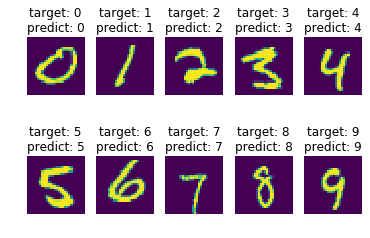

In [4]:
model_type = "cnn"
activation_type = "relu"
model = MNISTmodel(model_type, activation_type)
load_path = f"./trained/mnist/{model_type}-{activation_type}.pt"
model.load_state_dict(torch.load(load_path, map_location="cpu"))

preds = model_predict(model, imgs)
draw_numbers(preds, imgs, labels)

## Activation Maps

In [5]:
model.activation_maps.keys()

odict_keys(['(1) Conv2d>relu', '(4) Conv2d>relu', '(8) Linear>relu'])

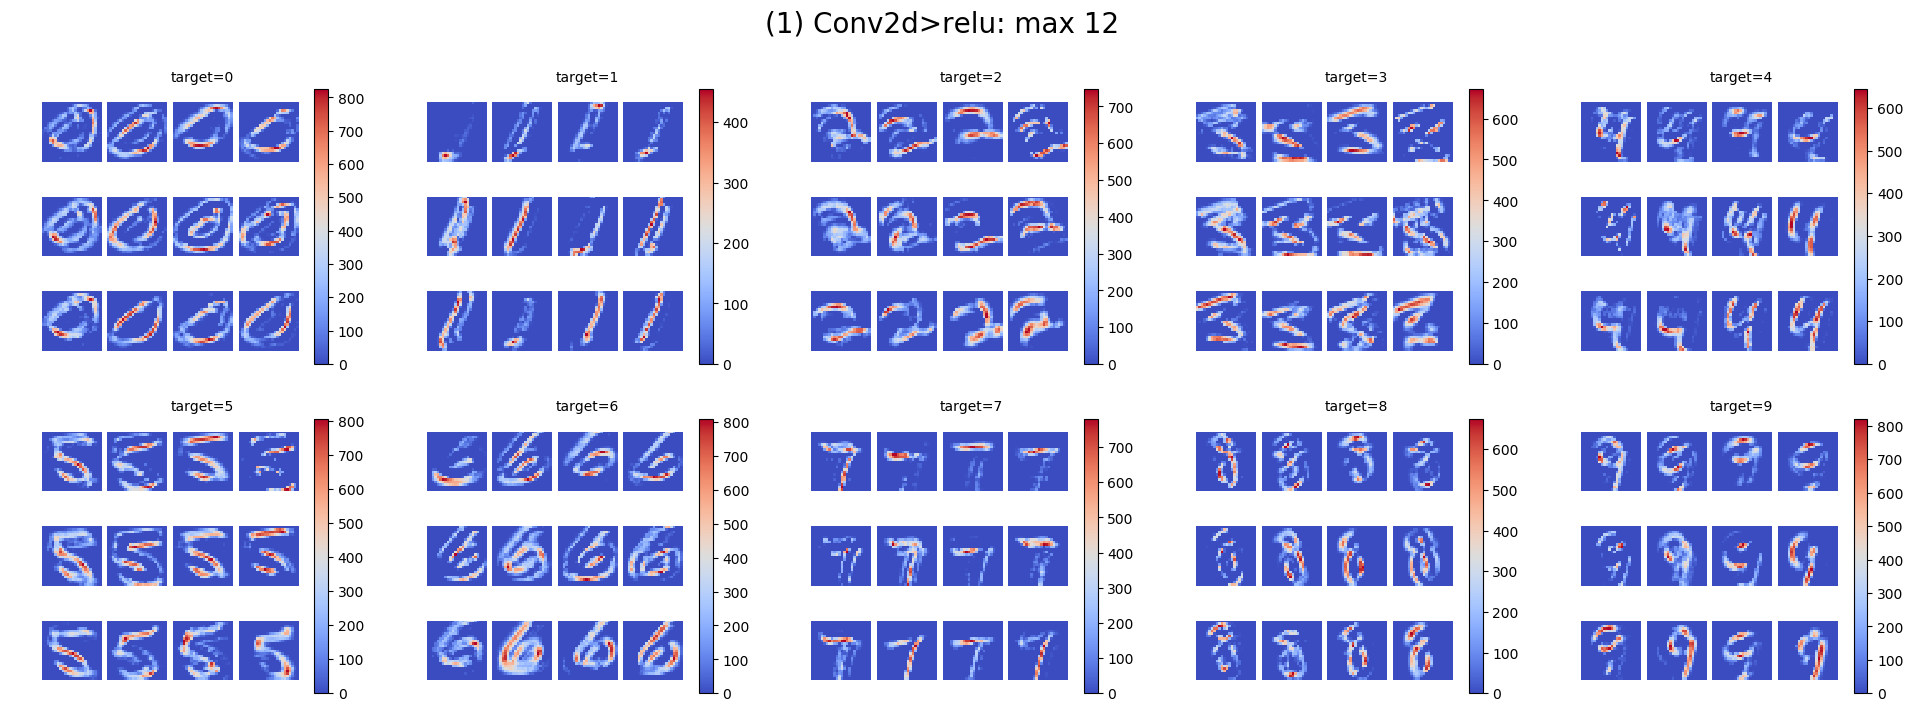

In [6]:
layer_name = "(1) Conv2d>relu"
max_num = 12
spaces = [(0.2, 0.2), (0.1, 0.1)]
figsize = (24, 8)
vis_row=2
vis_channel=3 
dpi=100
i_title_size = 10
draw_act_max(layer_name, model, max_num, spaces, figsize, vis_row, vis_channel, dpi, i_title_size, labels)

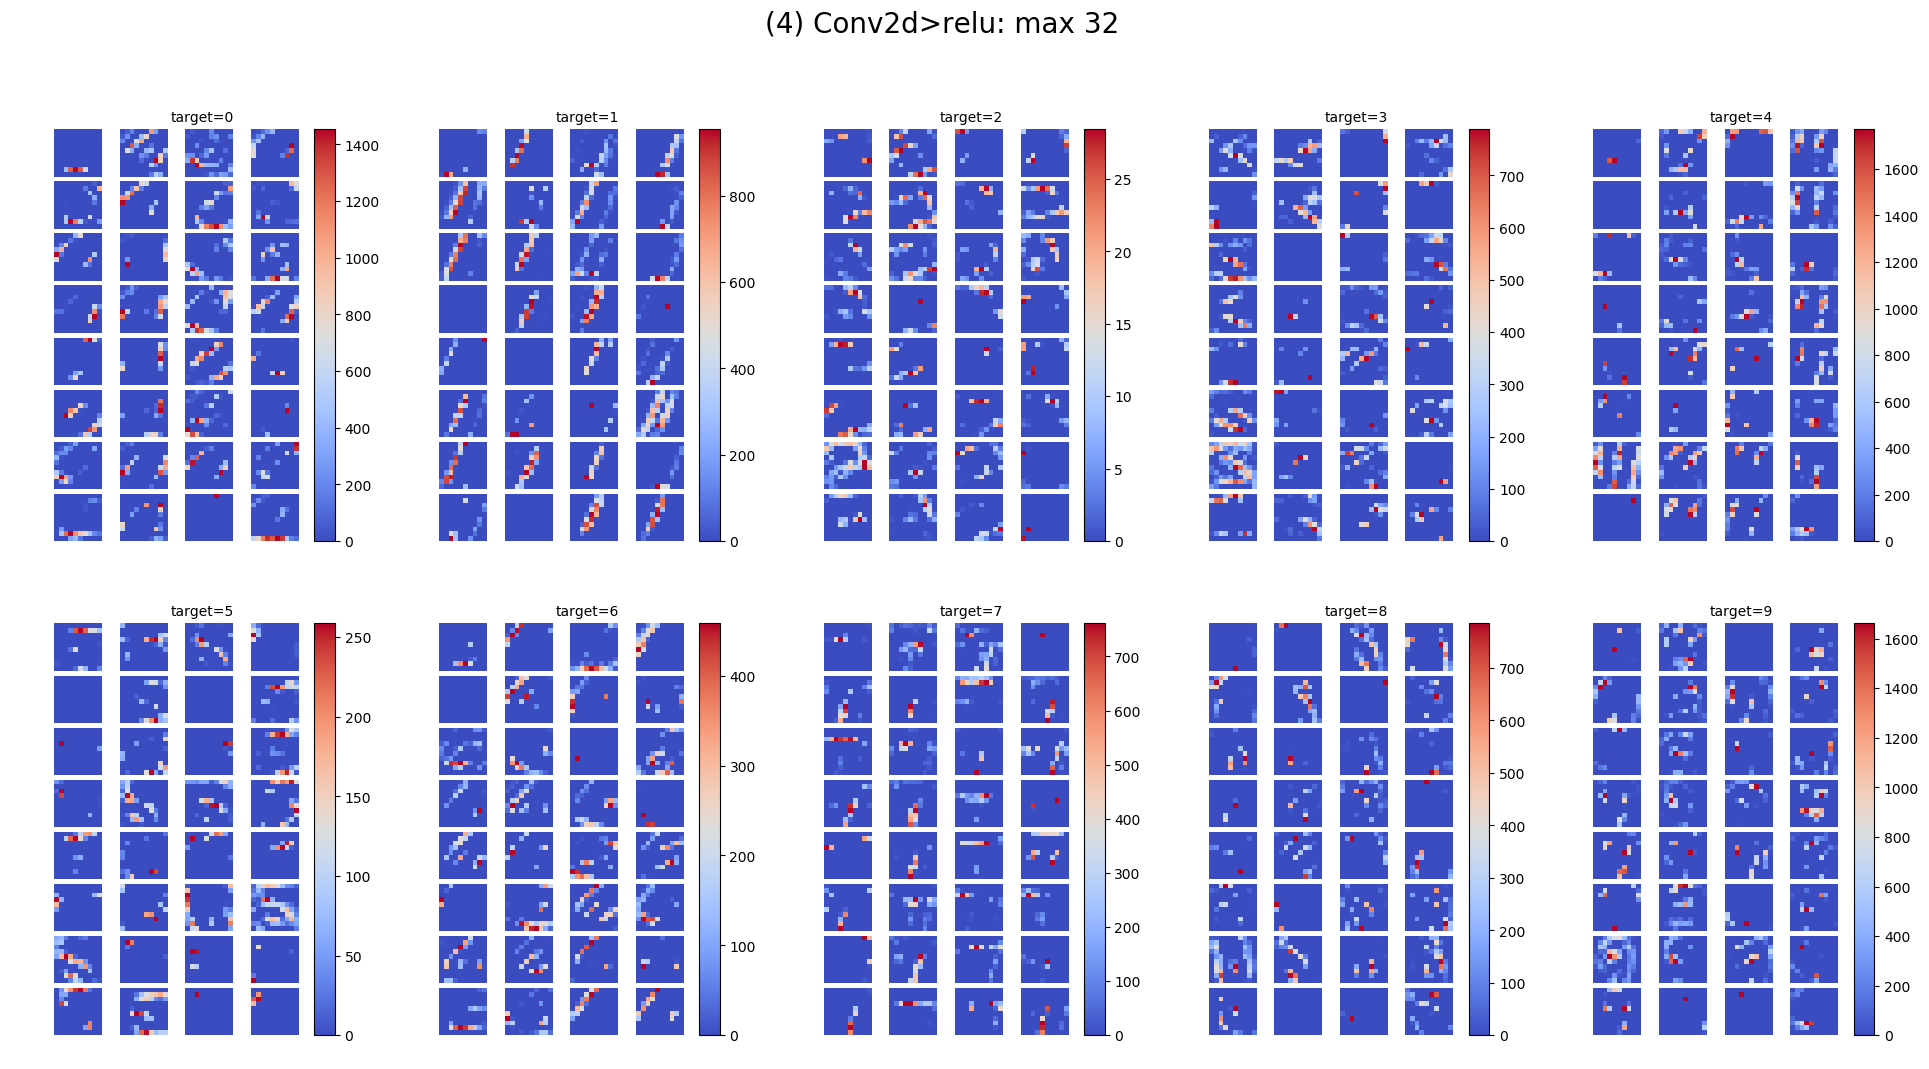

In [7]:
layer_name = "(4) Conv2d>relu"
figsize = (24, 12)
max_num = 32
vis_channel = 8
draw_act_max(layer_name, model, max_num, spaces, figsize, vis_row, vis_channel, dpi, i_title_size, labels)

## Deconvnet

`deconv_layer_num` is numbering from which deconv layers module(m =  "MaxPool > activation > Conv2d") numbering from the original cnn conv module(n = "Conv2d > activation > MaxPool")

for example:

```
deconv_layers = [m1, m2, m3, m4, m5]
if deconv_layer_num = 4, will goes from m4 to m5
* cnn_layer = [n5, n4, n3, n2, n1] (n.T = m, n5 is the first layer of cnn)
```

In [8]:
model.activation_maps.keys()

odict_keys(['(1) Conv2d>relu', '(4) Conv2d>relu', '(8) Linear>relu'])

torch.Size([10, 64, 5, 5])


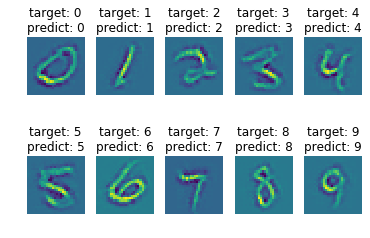

In [9]:
preds, _, switches = model_predict(model, imgs, get_switches=True)
deconvnet = DeconvNet(model)

deconv_layer_num = 1
layer_name = f"({deconvnet.deconv_locs[deconv_layer_num]}) Conv2d>relu>MaxPool2d" 
convs = model.activation_maps[layer_name]
deconv_outputs = deconvnet.deconv(convs, switches, deconv_layer_num, store=True).detach()
print(convs.size())

draw_numbers(preds, deconv_outputs, labels)

In [10]:
# deconv
vis_layers = deconvnet.activation_maps
vis_layers.keys()

odict_keys(['(2) ConvTranspose2d(in:64, out:32)', '(5) ConvTranspose2d(in:32, out:1)'])

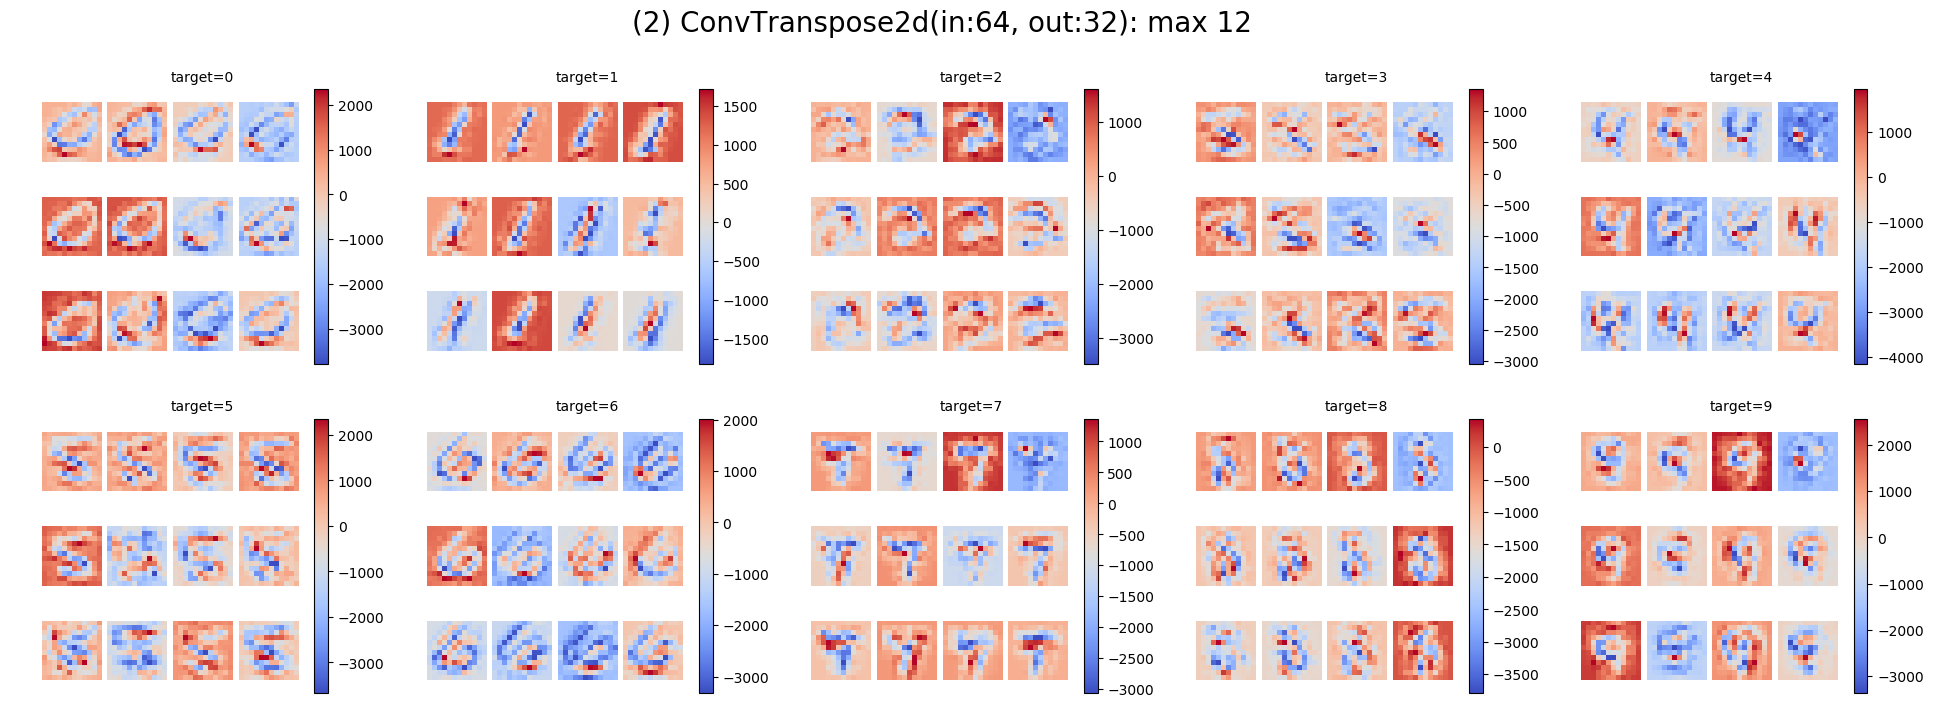

In [11]:
layer_name = "(2) ConvTranspose2d(in:64, out:32)"
figsize = (24, 8)
vis_row=2
vis_channel=3 
max_num = 12

draw_act_max(layer_name, deconvnet, max_num, spaces, figsize, vis_row, vis_channel, dpi, i_title_size, labels)

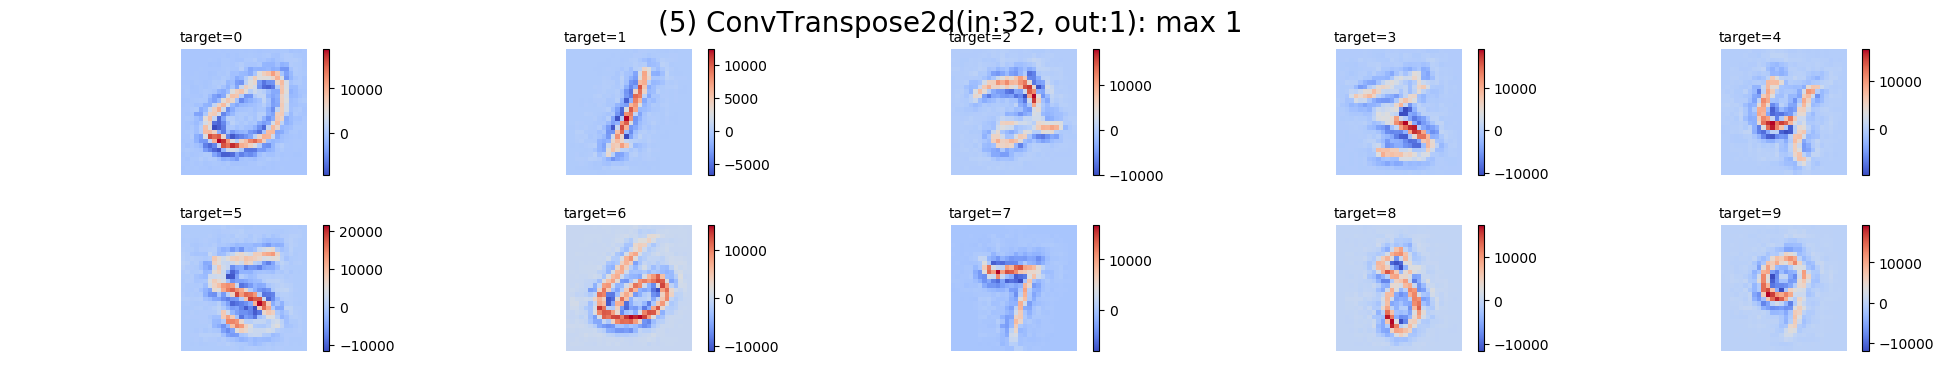

In [20]:
layer_name = "(5) ConvTranspose2d(in:32, out:1)"
spaces = [(0.2, 0.4), (0.1, 0.2)]
figsize = (24, 4)
max_num = 1
vis_row = 2
vis_channel=1
dpi = 100
i_title_size = 10

draw_act_max(layer_name, deconvnet, max_num, spaces, figsize, vis_row, vis_channel, dpi, i_title_size, labels)

## LRP

In [22]:
# lrp
lrp_model = LRP(model)
lrp_outputs = lrp_model.get_attribution(imgs, store=True, use_rho=False)

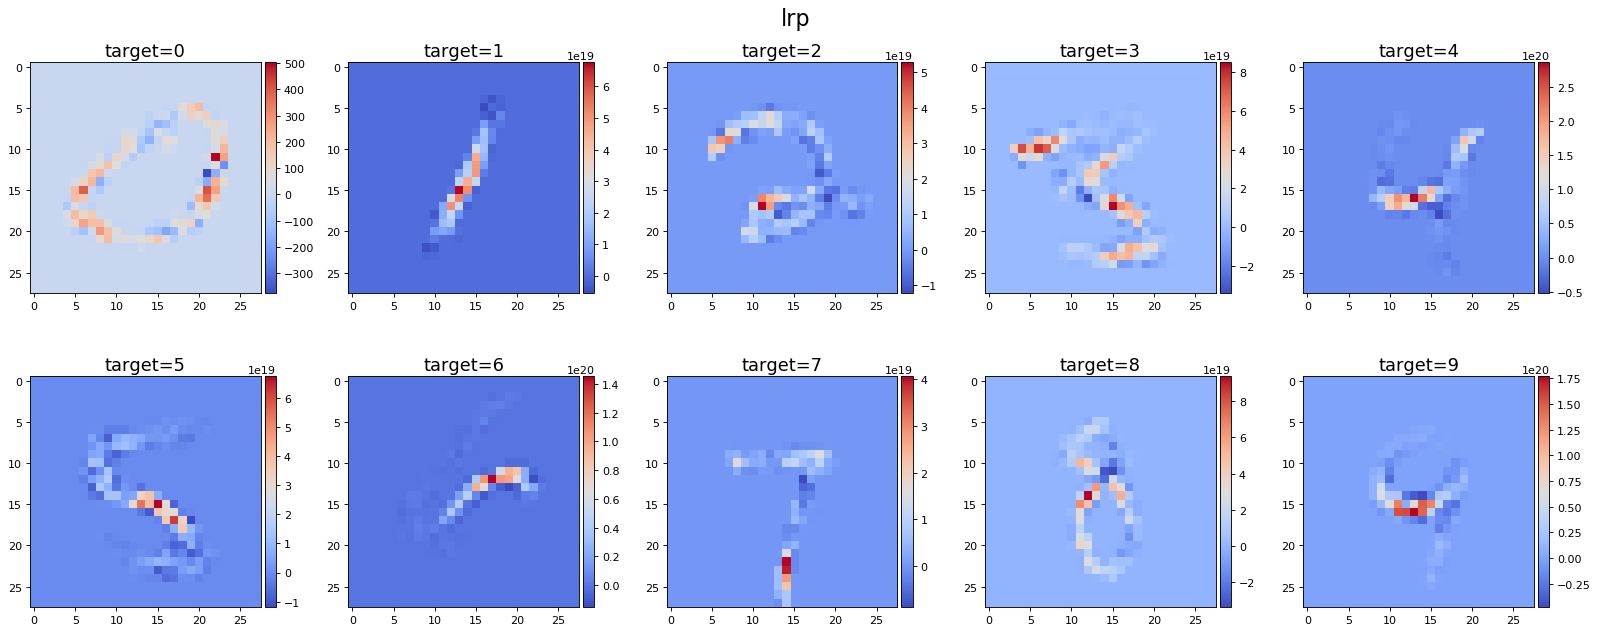

In [23]:
draw_attribution(lrp_outputs, "lrp", labels=labels, vis_row=2)

## Saliency

### Vanilla Gradient

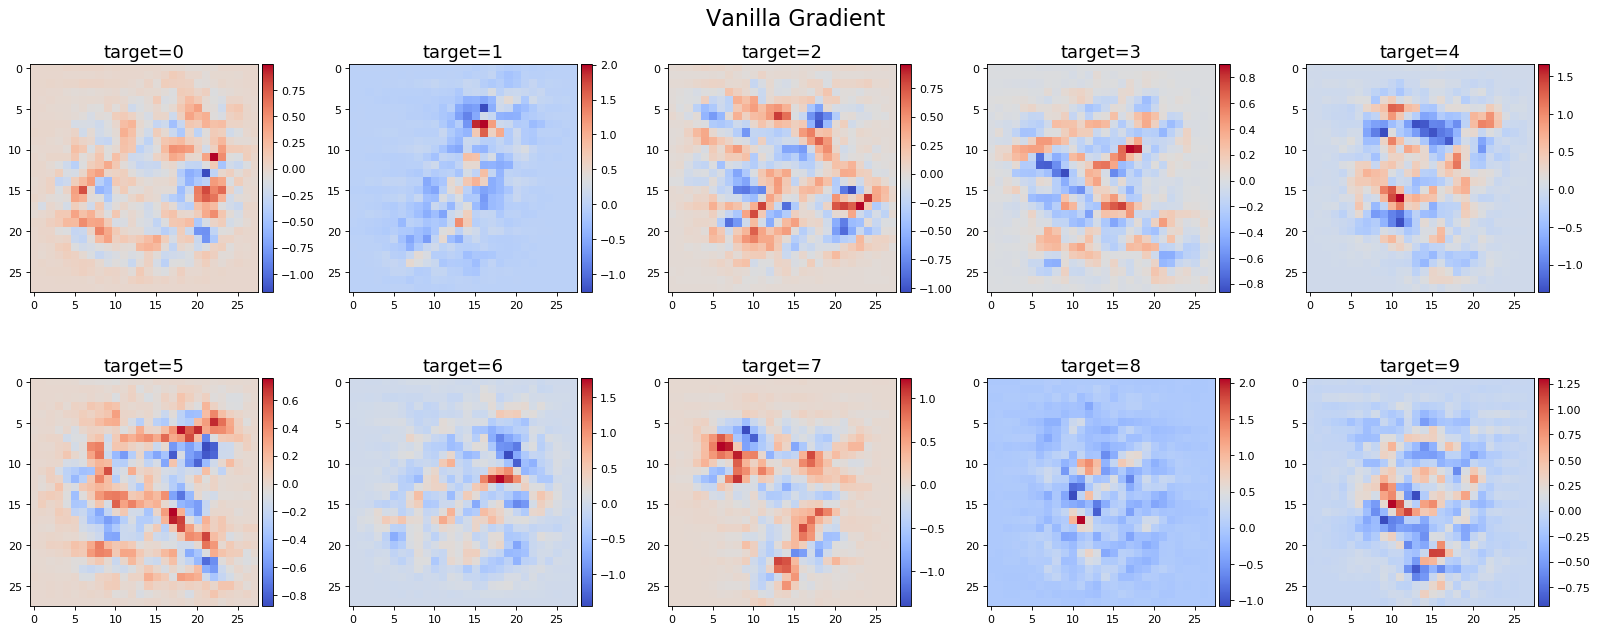

In [24]:
vanillagrad = VanillaGrad(model)
vanilla_outputs = vanillagrad.get_attribution(imgs, labels)
draw_attribution(vanilla_outputs, "Vanilla Gradient", labels=labels, vis_row=2)

### Gradient * Input

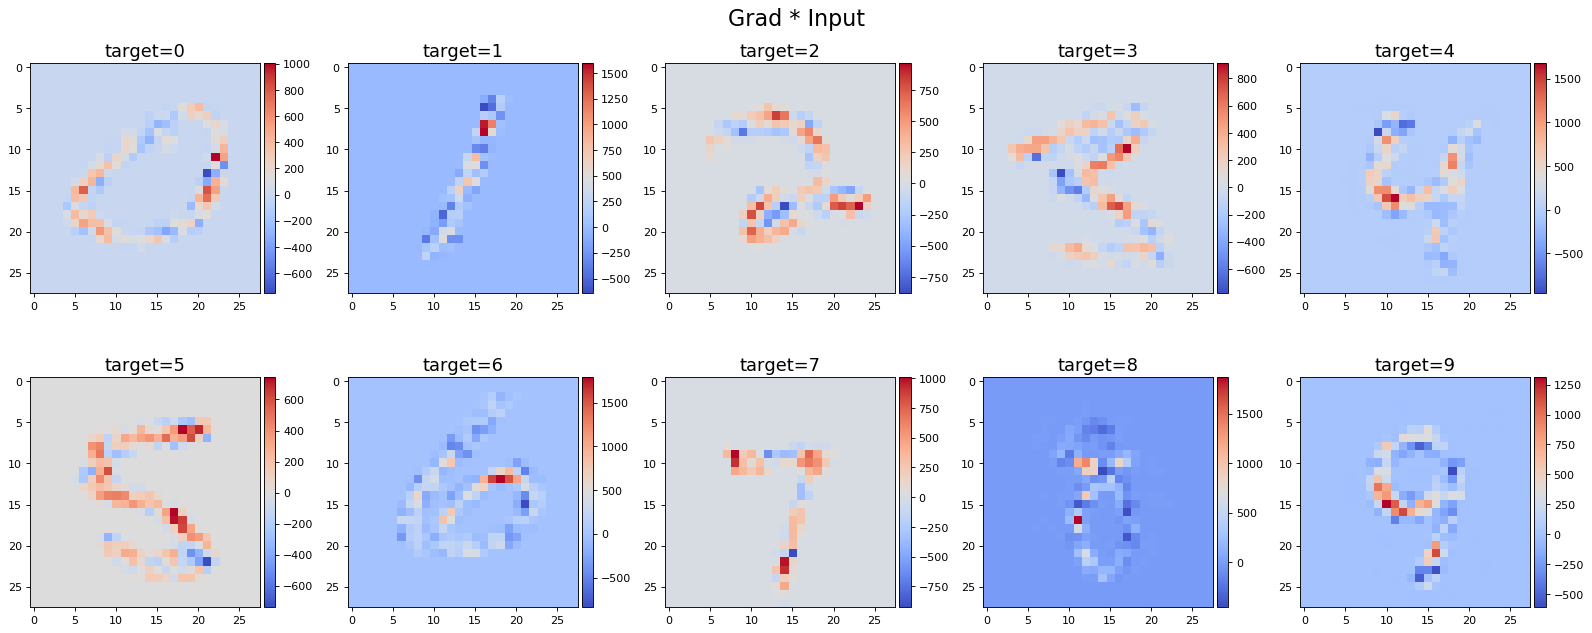

In [25]:
gradinput = GradInput(model)
gradinput_outputs = gradinput.get_attribution(imgs, labels)
draw_attribution(gradinput_outputs, "Grad * Input", labels=labels, vis_row=2)

---

# Evaluation of Attribution Methods - Quantitative

## Selectivity

Sensitivity 의 과정: 

1. attribution method 로 평가한다.
2. 최고 높은 attribution 픽셀을 지운다.
3. 다시 입력으로 해서 평가한다.


## ROAR

https://arxiv.org/abs/1806.10758

What would happen without re-training? 

The re-training is the most computationally expensive aspect of ROAR. One should question whether it is actually needed. We argue that re-training is needed because machine learning models **typically assume that the train and the test data comes from a similar distribution.**

The replacement value c can only be considered uninformative if the model is trained to learn it as such. Without retraining, it is unclear whether degradation in performance is **due to the introduction of artifacts outside of the original training distribution** or **because we actually removed information**. This is made explicit in our experiment in Section 4.3.1, we show that without retraining the degradation is far higher than the modest decrease in performance observed with re-training. This suggests retraining has better controlled for artefacts introduced by the modification.


ROAR 의 프로세스:

1. 첫번째 모델을 훈련 시킨다.
2. attribution method 로 평가를 한다(accuracy 측정).
3. 입력에 대한 attribution을 랭킹으로 세고 10%씩 차례차례 지운다.
4. 지운 데이터를 기반으로 다시 훈련시킨다(accuracy 측정).
5. 2~4 과정을 반복한다.

In [55]:
with (args["project_path"] / "trainlog" / "mnist-roar-record.txt").open() as f:
    x = f.read().splitlines()[2:]
    estimate_score = {"lrp": [], "gradinput": []}
    for l in x:
        splited_l = l.strip("|").split("|")
        if splited_l[2] == "lrp":
            estimate_score["lrp"].append(float(splited_l[-1].strip("%")))
        else:
            estimate_score["gradinput"].append(float(splited_l[-1].strip("%")))

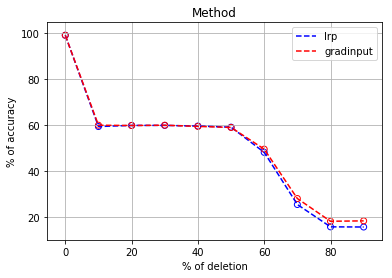

In [56]:
fig, ax = plt.subplots(1, 1)
xx = list(range(0, 100, 10))
ax.plot(xx, estimate_score["lrp"], "b--", label="lrp")
ax.scatter(xx, estimate_score["lrp"], facecolor="none", edgecolor="b")
ax.plot(xx, estimate_score["gradinput"], "r--", label="gradinput")
ax.scatter(xx, estimate_score["gradinput"], facecolor="none", edgecolor="r")
ax.legend()
ax.grid(True)
ax.set_xlabel("% of deletion")
ax.set_ylabel("% of accuracy")
ax.set_title("Method")
plt.show()

In [58]:
gradinput_masks = torch.load(args["project_path"] / args["sv_folder"] / "roar" / "gradinput" / "cnn-relu.masks")
lrp_masks = torch.load(args["project_path"] / args["sv_folder"] / "roar" / "lrp" / "cnn-relu.masks")

In [59]:
def deleted_load_model(model_type, activation_type, attr, del_p):
    path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / "roar" / f"{attr}" / f"{del_p}-cnn-relu.pt")
    model = MNISTmodel(model_type, activation_type)
    load_path = path_finder(attr, str(del_p))
    model.load_state_dict(torch.load(load_path, map_location="cpu"))
    return model

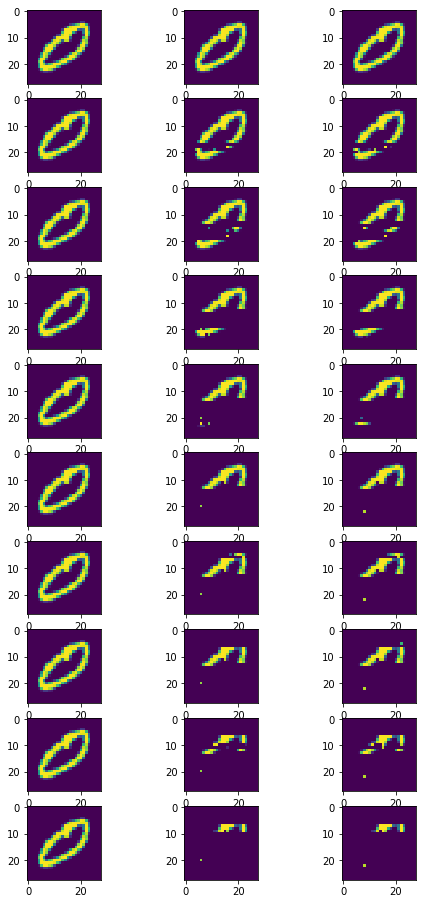

In [60]:
rnd_idx = torch.randint(0, test_dataset.data.size(0), size=(1, ))
img = test_dataset.data[rnd_idx]
# gradinput_mask = gradinput_masks[rnd_idx]
# lrp_mask = lrp_masks[rnd_idx]
delete_percentages = [round(x.item(), 2) for x in torch.arange(0, 1, 0.1)]
fig, axes = plt.subplots(10, 3, figsize=(8, 16))
for row_ax, del_p in zip(axes, delete_percentages):
    row_ax[0].imshow(img.squeeze())
    row_ax[1].imshow(img.squeeze() * lrp_masks[del_p][rnd_idx].eq(0).squeeze())
    row_ax[2].imshow(img.squeeze() * gradinput_masks[del_p][rnd_idx].eq(0).squeeze())

In [73]:
path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / f"{attr}" / f"{rel_p}-cnn-relu.pt")
model = MNISTmodel(model_type, activation_type)
load_path = path_finder("lrp", str(rel_p))
model.load_state_dict(torch.load(load_path, map_location="cpu"))

In [86]:
preds = model_predict(model, imgs)

In [92]:
attr_model = GradInput(model)
outputs = attr_model.get_attribution(imgs, labels)

In [229]:
B, C, H, W = outputs.size()
argmax_v = outputs.view(B, C, -1).argmax(-1)
row_max = argmax_v // W
col_max = argmax_v % W
max_indices = torch.cat([row_max, col_max], dim=-1)

In [44]:
path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / "roar" / f"{attr}" / f"{rel_p}-cnn-relu.pt")
model = MNISTmodel(model_type, activation_type)
load_path = path_finder("lrp", str(0.1))
model.load_state_dict(torch.load(load_path, map_location="cpu"))

*_, test_loader = build_dataset(str(args["root"]), 5)
for data, target in test_loader:
    output = model(data)
    
    pred = output.argmax(dim=1, keepdim=True)
    
    break
#     correct += pred.eq(target.view_as(pred)).sum().item()

In [45]:
target

tensor([6, 1, 8, 1, 2])

In [46]:
pred

tensor([[6],
        [6],
        [2],
        [6],
        [2]])